#Download and Install Essential packages
Here we had to add NVIDIA drivers and CUDA framework with python 3.10 version
(This code will only work on python 3.10 dependencies)

In [ ]:
!pip install -U scikit-learn imbalanced-learn xgboost ucimlrepo joblib seaborn matplotlib --quiet
!nvidia-smi

Thu Apr 10 20:20:33 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   53C    P0             29W /   70W |     120MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

#Loaded the packages

In [ ]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import joblib
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import AdaBoostClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score, roc_auc_score,
    mean_squared_error, mean_absolute_error, confusion_matrix, classification_report, roc_curve
)
import xgboost as xgb
from imblearn.over_sampling import SMOTE
from ucimlrepo import fetch_ucirepo


Sourced the Dataset from UCI repository

In [ ]:
from google.colab import drive
from pathlib import Path
drive.mount('/content/drive')
output_dir = "/content/drive/MyDrive/diabetes_model_output"
os.makedirs(output_dir, exist_ok=True)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
data = fetch_ucirepo(id=891)
X = data.data.features
y = np.ravel(data.data.targets.values)

# Rewant's Part

Used SMOTE Method to balance the classes

In [ ]:
print("SMOTE Method")
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)
X_train_res, y_train_res = SMOTE(random_state=42).fit_resample(X_train, y_train)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_res)
X_test_scaled = scaler.transform(X_test)
joblib.dump(scaler, os.path.join(output_dir, "scaler.pkl"))

SMOTE Method


['/content/drive/MyDrive/diabetes_model_output/scaler.pkl']

# XG boost Model with parameters

In [ ]:
xgb_model = xgb.XGBClassifier(
    objective="binary:logistic",
    eval_metric="logloss",
    enable_categorical=False
).set_params(tree_method="hist", device="cuda")

xgb_param_grid = {
    "max_depth": [3],
    "learning_rate": [0.1],
    "n_estimators": [100],
    "gamma": [0],
    "colsample_bytree": [1.0]
}
xgb_grid = GridSearchCV(xgb_model, xgb_param_grid, cv=5, scoring="roc_auc", verbose=1)
xgb_grid.fit(X_train_scaled, y_train_res)
xgb_best = xgb_grid.best_estimator_
y_pred_xgb = xgb_best.predict(X_test_scaled)
y_prob_xgb = xgb_best.predict_proba(X_test_scaled)[:, 1]
joblib.dump(xgb_best, os.path.join(output_dir, "xgboost_model.pkl"))

Fitting 5 folds for each of 1 candidates, totalling 5 fits


['/content/drive/MyDrive/diabetes_model_output/xgboost_model.pkl']

# ADA Boost model with parameters

In [ ]:
ada_model = AdaBoostClassifier(random_state=42)
ada_param_grid = {
    'n_estimators': [50, 100, 200],
    'learning_rate': [0.01, 0.1, 1.0]
}
ada_grid = GridSearchCV(estimator=ada_model, param_grid=ada_param_grid, scoring='roc_auc', cv=5, verbose=1)
ada_grid.fit(X_train_scaled, y_train_res)
ada_best = ada_grid.best_estimator_
y_pred_ada = ada_best.predict(X_test_scaled)
y_prob_ada = ada_best.predict_proba(X_test_scaled)[:, 1]
joblib.dump(ada_best, os.path.join(output_dir, 'adaboost_model.pkl'))

Fitting 5 folds for each of 9 candidates, totalling 45 fits


['/content/drive/MyDrive/diabetes_model_output/adaboost_model.pkl']

In [ ]:
def evaluate(name, y_true, y_pred, y_prob, model):
    print(f"\n{name} Evaluation")
    metrics = {
        "Accuracy": accuracy_score(y_true, y_pred),
        "Precision": precision_score(y_true, y_pred),
        "Recall": recall_score(y_true, y_pred),
        "F1 Score": f1_score(y_true, y_pred),
        "AUC": roc_auc_score(y_true, y_prob),
        "MSE": mean_squared_error(y_true, y_prob),
        "MAE": mean_absolute_error(y_true, y_prob),
        "Correlation": np.corrcoef(y_true, y_prob)[0, 1]
    }
    for k, v in metrics.items():
        print(f"{k}: {v:.4f}")
    print("\nConfusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred))

    plt.figure(figsize=(10, 5))
    sns.barplot(x=list(metrics.keys()), y=list(metrics.values()))
    plt.title(f"{name} - Metrics")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_metrics.png"))
    plt.close()

    fpr, tpr, _ = roc_curve(y_true, y_prob)
    plt.figure(figsize=(6, 5))
    plt.plot(fpr, tpr, label=f"AUC = {metrics['AUC']:.4f}")
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f"{name} - ROC Curve")
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_roc_curve.png"))
    plt.close()

    for metric in ["F1 Score", "MSE", "MAE"]:
        plt.figure()
        plt.bar(metric, metrics[metric])
        plt.title(f"{name} - {metric}")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{name.lower()}_{metric.lower().replace(' ', '_')}.png"))
        plt.close()

    if hasattr(model, "feature_importances_"):
        plt.figure(figsize=(10, 6))
        sns.barplot(x=model.feature_importances_, y=X.columns)
        plt.title(f"{name} - Feature Importance")
        plt.tight_layout()
        plt.savefig(os.path.join(output_dir, f"{name.lower()}_features.png"))
        plt.close()

    plt.figure(figsize=(6, 5))
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt='d', cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.tight_layout()
    plt.savefig(os.path.join(output_dir, f"{name.lower()}_confusion.png"))
    plt.close()

In [ ]:
evaluate("XGBoost", y_test, y_pred_xgb, y_prob_xgb, xgb_best)
evaluate("AdaBoost", y_test, y_pred_ada, y_prob_ada, ada_best)


XGBoost Evaluation
Accuracy: 0.7130
Precision: 0.2902
Recall: 0.7331
F1 Score: 0.4158
AUC: 0.7897
MSE: 0.1790
MAE: 0.3495
Correlation: 0.3557

Confusion Matrix:
 [[30993 12674]
 [ 1887  5182]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.71      0.81     43667
           1       0.29      0.73      0.42      7069

    accuracy                           0.71     50736
   macro avg       0.62      0.72      0.61     50736
weighted avg       0.85      0.71      0.75     50736


AdaBoost Evaluation
Accuracy: 0.7212
Precision: 0.2933
Recall: 0.7101
F1 Score: 0.4151
AUC: 0.7881
MSE: 0.2161
MAE: 0.4607
Correlation: 0.3396

Confusion Matrix:
 [[31571 12096]
 [ 2049  5020]]

Classification Report:
               precision    recall  f1-score   support

           0       0.94      0.72      0.82     43667
           1       0.29      0.71      0.42      7069

    accuracy                           0.72     50736
   macro avg    

In [ ]:
sample = pd.DataFrame([{
    "HighBP": 1, "HighChol": 1, "CholCheck": 1, "BMI": 30, "Smoker": 0,
    "Stroke": 0, "HeartDiseaseorAttack": 0, "PhysActivity": 1, "Fruits": 1,
    "Veggies": 1, "HvyAlcoholConsump": 0, "AnyHealthcare": 1, "NoDocbcCost": 0,
    "GenHlth": 2, "MentHlth": 0, "PhysHlth": 0, "DiffWalk": 0, "Sex": 1,
    "Age": 8, "Education": 5, "Income": 6
}])
scaled = scaler.transform(sample)
pred = xgb_best.predict(scaled)[0]
prob = xgb_best.predict_proba(scaled)[0, 1]
print(f"\nPrediction: {pred} ({'Positive' if pred else 'Negative'}) | Probability: {prob:.4f}")



Prediction: 1 (Positive) | Probability: 0.5410


#Genevieve's part :

In [ ]:
# Classification Tree Function

def train_classification_tree(X_train, y_train, X_test, y_test):
    """Train and tune Classification Tree model"""
    print("\n" + "="*50)
    print("Training Classification Tree model with hyperparameter tuning...")

    n_classes = len(np.unique(y_train))
    is_multiclass = n_classes > 2
    print(f"Number of target classes: {n_classes}")

    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    }

    dt = DecisionTreeClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=dt,
        param_grid=param_grid,
        cv=3,
        scoring='balanced_accuracy' if is_multiclass else 'roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_dt = grid_search.best_estimator_

    print("\nBest Parameters for Classification Tree:")
    print(best_dt)

    y_pred_dt = best_dt.predict(X_test)
    y_prob_dt = best_dt.predict_proba(X_test)[:, 1]

    evaluate("ClassificationTree", y_test, y_pred_dt, y_prob_dt, best_dt)

    return best_dt


In [ ]:
# Random Forest

def train_random_forest(X_train, y_train, X_test, y_test):
    """Train and tune Random Forest model"""
    print("\n" + "="*50)
    print("Training Random Forest model with hyperparameter tuning...")

    n_classes = len(np.unique(y_train))
    is_multiclass = n_classes > 2
    print(f"Number of target classes: {n_classes}")

    param_grid = {
        'max_depth': [None, 10, 20, 30],
        'min_samples_split': [2, 5, 10],
        'min_samples_leaf': [1, 2, 4],
        'class_weight': [None, 'balanced']
    }

    rf = RandomForestClassifier(random_state=42)

    grid_search = GridSearchCV(
        estimator=rf,
        param_grid=param_grid,
        cv=3,
        scoring='balanced_accuracy' if is_multiclass else 'roc_auc',
        n_jobs=-1,
        verbose=1
    )

    grid_search.fit(X_train, y_train)

    best_rf = grid_search.best_estimator_

    print("\nBest Parameters for Random Forest:")
    print(grid_search.best_params_)

    y_pred_rf = best_rf.predict(X_test)
    y_prob_rf = best_rf.predict_proba(X_test)[:, 1]

    evaluate("RandomForestGrid", y_test, y_pred_rf, y_prob_rf, best_rf)

    return best_rf



Training Classification Tree model with hyperparameter tuning...
Number of target classes: 2
Fitting 3 folds for each of 72 candidates, totalling 216 fits

Best Parameters for Classification Tree:
DecisionTreeClassifier(min_samples_leaf=4, min_samples_split=10,
                       random_state=42)

ClassificationTree Evaluation
Accuracy: 0.7371
Precision: 0.2507
Recall: 0.4457
F1 Score: 0.3209
AUC: 0.6756
MSE: 0.2117
MAE: 0.2826
Correlation: 0.2249

Confusion Matrix:
 [[34248  9419]
 [ 3918  3151]]

Classification Report:
               precision    recall  f1-score   support

           0       0.90      0.78      0.84     43667
           1       0.25      0.45      0.32      7069

    accuracy                           0.74     50736
   macro avg       0.57      0.62      0.58     50736
weighted avg       0.81      0.74      0.77     50736


Training Random Forest model with hyperparameter tuning...
Number of target classes: 2
Fitting 3 folds for each of 72 candidates, totalling

/usr/local/lib/python3.11/dist-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(



Best Parameters for Random Forest:
{'class_weight': None, 'max_depth': 30, 'min_samples_leaf': 1, 'min_samples_split': 2}

RandomForestGrid Evaluation
Accuracy: 0.7864
Precision: 0.3225
Recall: 0.4839
F1 Score: 0.3871
AUC: 0.7689
MSE: 0.1451
MAE: 0.2819
Correlation: 0.3287

Confusion Matrix:
 [[36480  7187]
 [ 3648  3421]]

Classification Report:
               precision    recall  f1-score   support

           0       0.91      0.84      0.87     43667
           1       0.32      0.48      0.39      7069

    accuracy                           0.79     50736
   macro avg       0.62      0.66      0.63     50736
weighted avg       0.83      0.79      0.80     50736



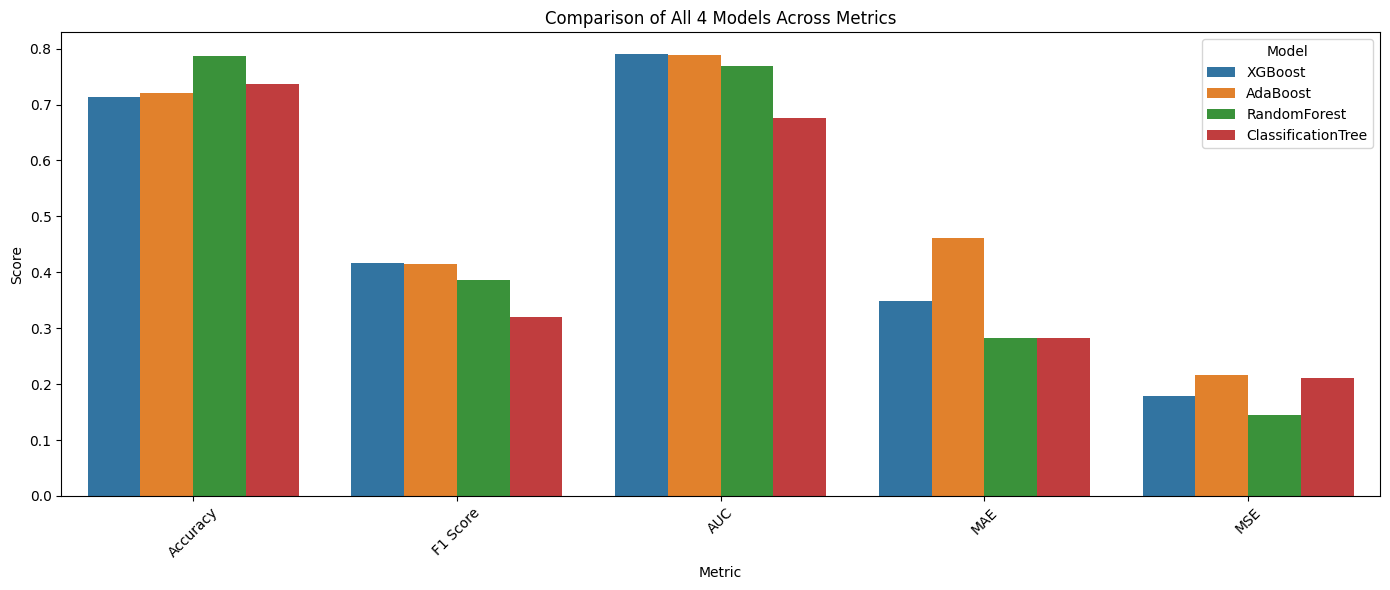

,Model,Accuracy,F1 Score,AUC,MAE,MSE
0,XGBoost,0.713005,0.415807,0.789691,0.349504,0.179003
1,AdaBoost,0.721204,0.415133,0.788069,0.460686,0.216144
2,RandomForest,0.786444,0.387057,0.768931,0.281919,0.145148
3,ClassificationTree,0.737129,0.320892,0.675641,0.282626,0.211743


In [ ]:
#  Run and compare all 4 models

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

# Train classification tree
clf_tree = train_classification_tree(X_train_scaled, y_train_res, X_test_scaled, y_test)
y_pred_tree = clf_tree.predict(X_test_scaled)
y_prob_tree = clf_tree.predict_proba(X_test_scaled)[:, 1]

# Train tuned random forest
clf_rf = train_random_forest(X_train_scaled, y_train_res, X_test_scaled, y_test)
y_pred_rf_grid = clf_rf.predict(X_test_scaled)
y_prob_rf_grid = clf_rf.predict_proba(X_test_scaled)[:, 1]

# Collect all model metrics
comparison_df = pd.DataFrame({
    "Model": ["XGBoost", "AdaBoost", "RandomForest", "ClassificationTree"],
    "Accuracy": [accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_ada), accuracy_score(y_test, y_pred_rf_grid), accuracy_score(y_test, y_pred_tree)],
    "F1 Score": [f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_ada), f1_score(y_test, y_pred_rf_grid), f1_score(y_test, y_pred_tree)],
    "AUC": [roc_auc_score(y_test, y_prob_xgb), roc_auc_score(y_test, y_prob_ada), roc_auc_score(y_test, y_prob_rf_grid), roc_auc_score(y_test, y_prob_tree)],
    "MAE": [mean_absolute_error(y_test, y_prob_xgb), mean_absolute_error(y_test, y_prob_ada), mean_absolute_error(y_test, y_prob_rf_grid), mean_absolute_error(y_test, y_prob_tree)],
    "MSE": [mean_squared_error(y_test, y_prob_xgb), mean_squared_error(y_test, y_prob_ada), mean_squared_error(y_test, y_prob_rf_grid), mean_squared_error(y_test, y_prob_tree)]
})

# Save comparison as CSV
comparison_df.to_csv(os.path.join(output_dir, "model_comparison_all4.csv"), index=False)

# Plot comparison chart
plt.figure(figsize=(14, 6))
melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.title("Comparison of All 4 Models Across Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_comparison_all4.png"))
plt.show()

comparison_df



# Conclusions

# BIAS V/S VARIANCE CURVE

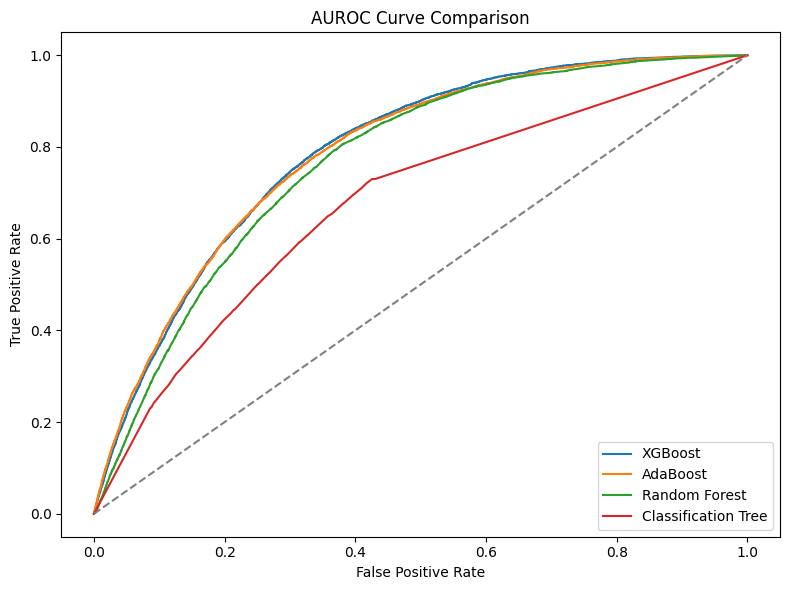

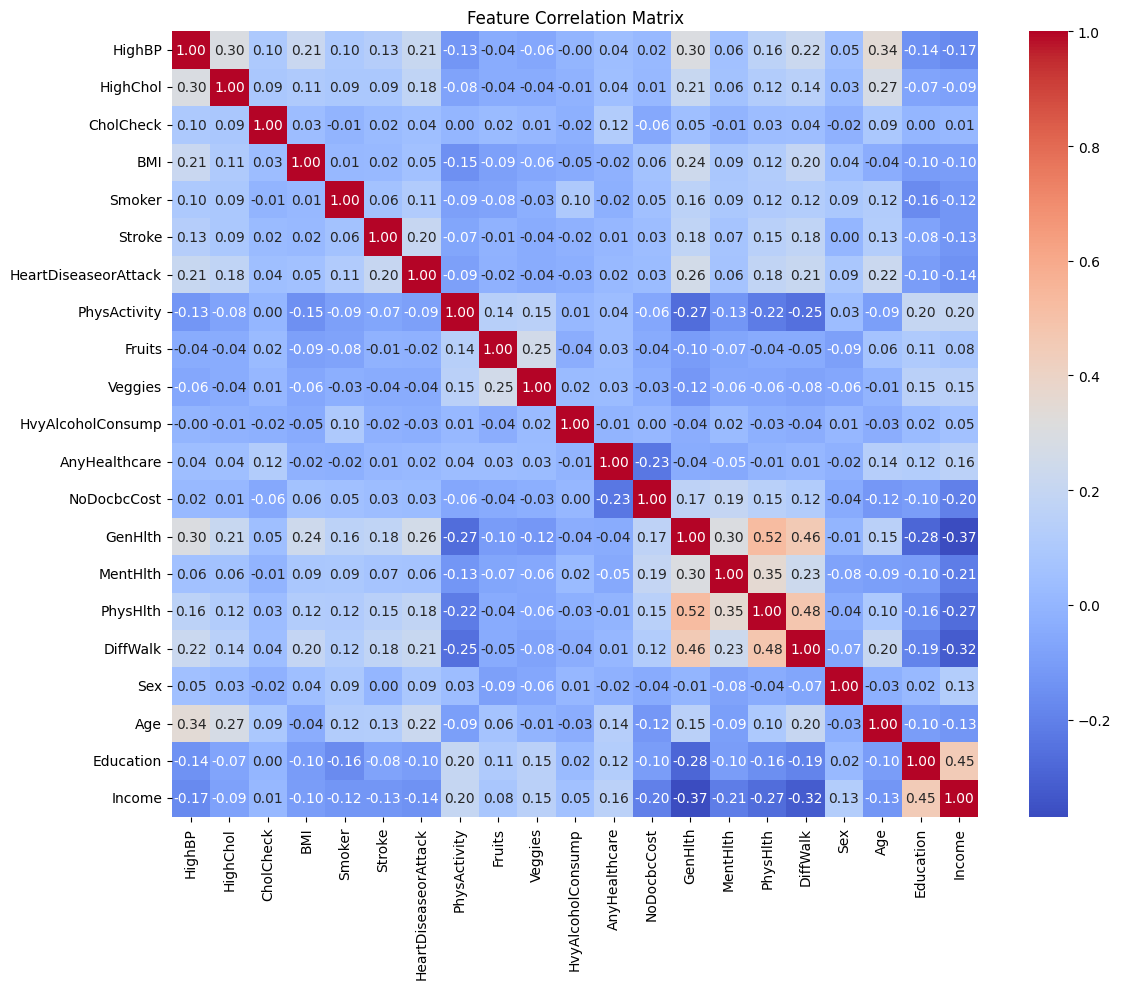

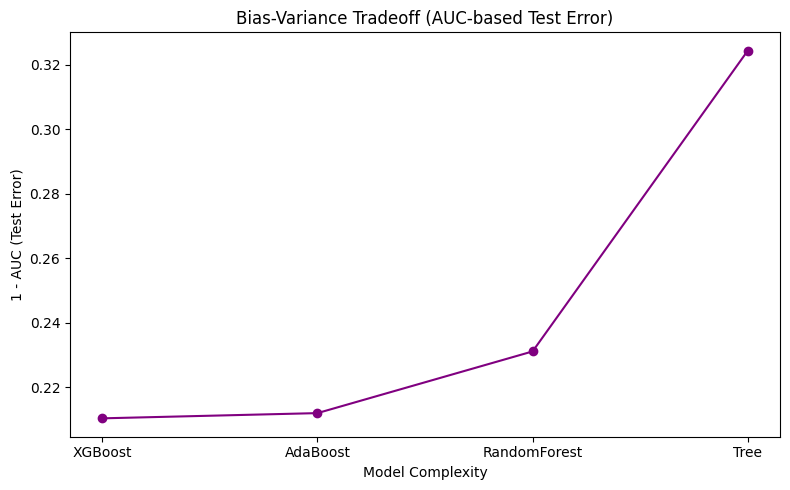

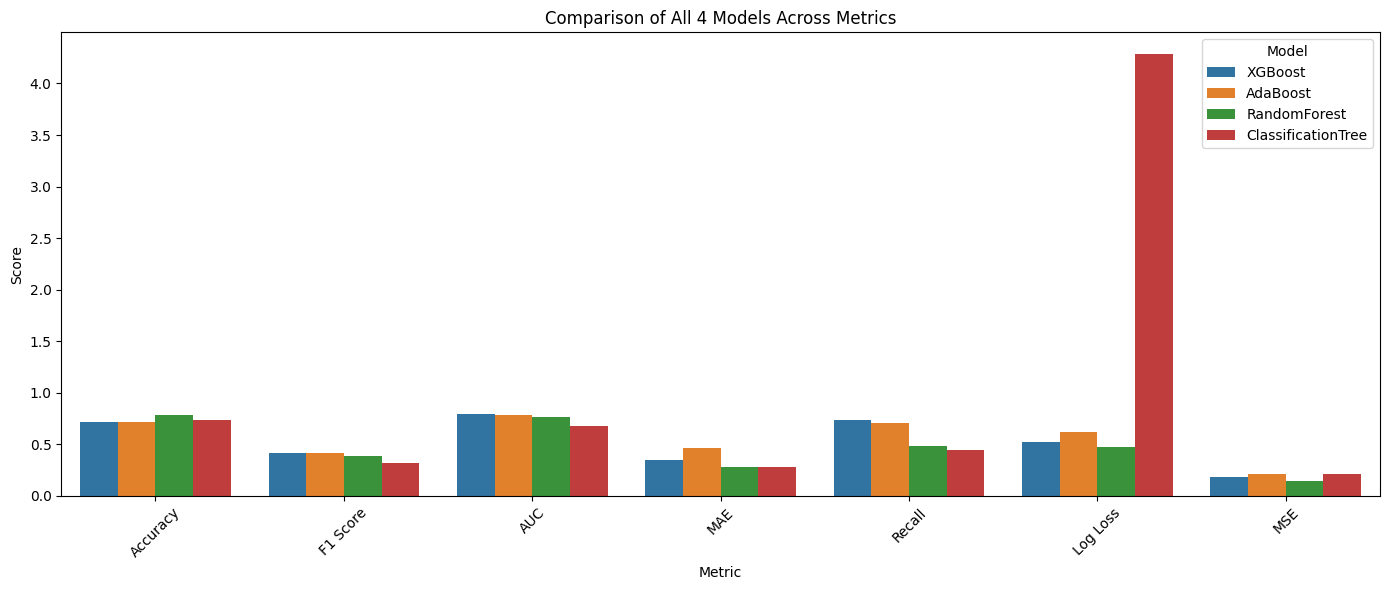

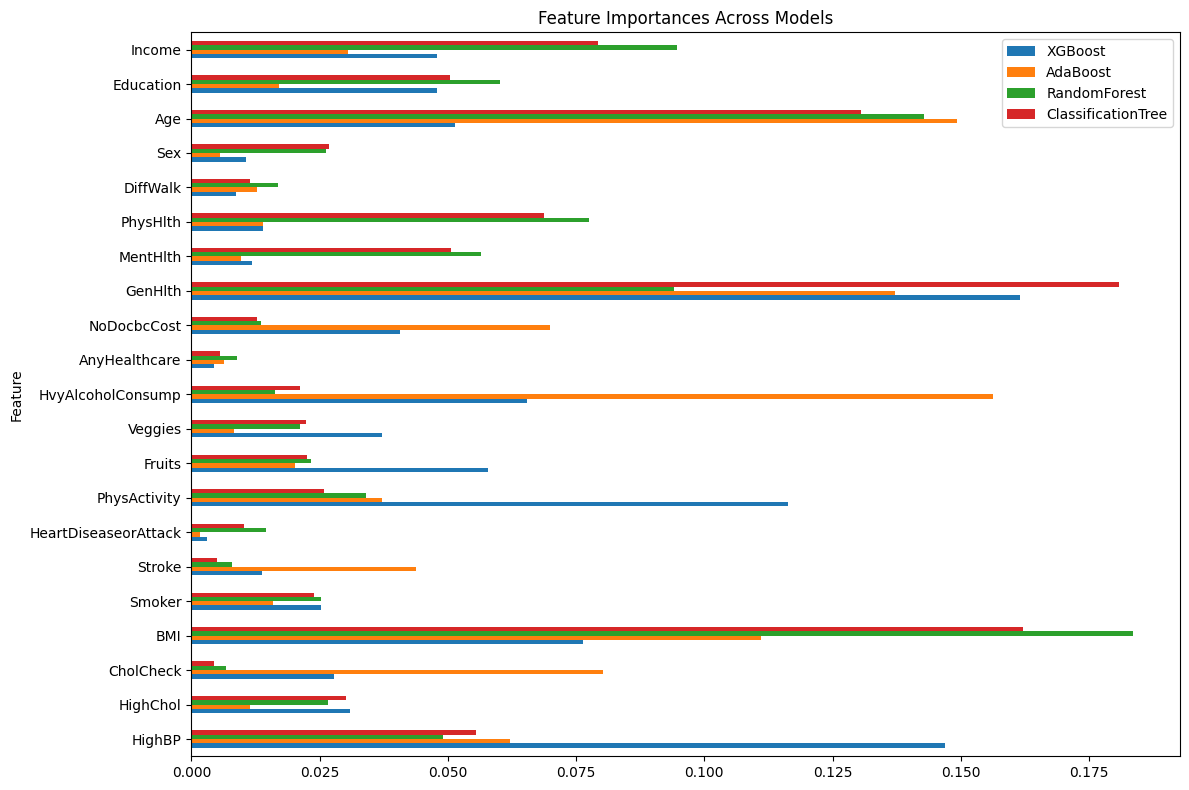

,Model,Accuracy,F1 Score,AUC,MAE,Recall,Log Loss,MSE
0,XGBoost,0.713005,0.415807,0.789691,0.349504,0.733060,0.522844,0.179003
1,AdaBoost,0.721204,0.415133,0.788069,0.460686,0.710143,0.624232,0.216144
2,RandomForest,0.786444,0.387057,0.768931,0.281919,0.483944,0.472300,0.145148
3,ClassificationTree,0.737129,0.320892,0.675641,0.282626,0.445749,4.281942,0.211743


In [ ]:
# AUROC Curves, Correlation Matrix, Feature Importances, and Comparison Table

# Plot AUROC Curves
plt.figure(figsize=(8, 6))
fpr_xgb, tpr_xgb, _ = roc_curve(y_test, y_prob_xgb)
fpr_ada, tpr_ada, _ = roc_curve(y_test, y_prob_ada)
fpr_rf, tpr_rf, _ = roc_curve(y_test, y_prob_rf_grid)
fpr_tree, tpr_tree, _ = roc_curve(y_test, y_prob_tree)

plt.plot(fpr_xgb, tpr_xgb, label='XGBoost')
plt.plot(fpr_ada, tpr_ada, label='AdaBoost')
plt.plot(fpr_rf, tpr_rf, label='Random Forest')
plt.plot(fpr_tree, tpr_tree, label='Classification Tree')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('AUROC Curve Comparison')
plt.legend(loc='lower right')
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "auroc_curve_all_models.png"))
plt.show()

# Correlation Matrix
plt.figure(figsize=(12, 10))
sns.heatmap(X.corr(), annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Feature Correlation Matrix")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_correlation_matrix.png"))
plt.show()

# Build comparison DataFrame including Recall
# Plot Bias vs Variance Curve (proxy: model complexity vs test error)
model_complexity = [1, 2, 3, 4]  # 4 models
test_error = [1 - roc_auc_score(y_test, y_prob_xgb),
              1 - roc_auc_score(y_test, y_prob_ada),
              1 - roc_auc_score(y_test, y_prob_rf_grid),
              1 - roc_auc_score(y_test, y_prob_tree)]

plt.figure(figsize=(8, 5))
plt.plot(model_complexity, test_error, marker='o', linestyle='-', color='purple')
plt.xticks(model_complexity, ["XGBoost", "AdaBoost", "RandomForest", "Tree"])
plt.title("Bias-Variance Tradeoff (AUC-based Test Error)")
plt.xlabel("Model Complexity")
plt.ylabel("1 - AUC (Test Error)")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "bias_variance_curve.png"))
plt.show()

from sklearn.metrics import log_loss

comparison_df = pd.DataFrame({
    "Model": ["XGBoost", "AdaBoost", "RandomForest", "ClassificationTree"],
    "Accuracy": [accuracy_score(y_test, y_pred_xgb), accuracy_score(y_test, y_pred_ada), accuracy_score(y_test, y_pred_rf_grid), accuracy_score(y_test, y_pred_tree)],
    "F1 Score": [f1_score(y_test, y_pred_xgb), f1_score(y_test, y_pred_ada), f1_score(y_test, y_pred_rf_grid), f1_score(y_test, y_pred_tree)],
    "AUC": [roc_auc_score(y_test, y_prob_xgb), roc_auc_score(y_test, y_prob_ada), roc_auc_score(y_test, y_prob_rf_grid), roc_auc_score(y_test, y_prob_tree)],
    "MAE": [mean_absolute_error(y_test, y_prob_xgb), mean_absolute_error(y_test, y_prob_ada), mean_absolute_error(y_test, y_prob_rf_grid), mean_absolute_error(y_test, y_prob_tree)],
    "Recall": [recall_score(y_test, y_pred_xgb), recall_score(y_test, y_pred_ada), recall_score(y_test, y_pred_rf_grid), recall_score(y_test, y_pred_tree)],
    "Log Loss": [log_loss(y_test, y_prob_xgb), log_loss(y_test, y_prob_ada), log_loss(y_test, y_prob_rf_grid), log_loss(y_test, y_prob_tree)],
    "MSE": [mean_squared_error(y_test, y_prob_xgb), mean_squared_error(y_test, y_prob_ada), mean_squared_error(y_test, y_prob_rf_grid), mean_squared_error(y_test, y_prob_tree)]
})

# Save comparison as CSV
comparison_df.to_csv(os.path.join(output_dir, "model_comparison_all4.csv"), index=False)

# Plot comparison chart
plt.figure(figsize=(14, 6))
melted = comparison_df.melt(id_vars="Model", var_name="Metric", value_name="Score")
sns.barplot(data=melted, x="Metric", y="Score", hue="Model")
plt.title("Comparison of All 4 Models Across Metrics")
plt.xticks(rotation=45)
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "model_comparison_all4.png"))
plt.show()

# Feature Importance Extraction
feature_importances = pd.DataFrame({
    'Feature': X.columns,
    'XGBoost': xgb_best.feature_importances_,
    'AdaBoost': ada_best.feature_importances_,
    'RandomForest': clf_rf.feature_importances_,
    'ClassificationTree': clf_tree.feature_importances_
})

feature_importances_pct = feature_importances.set_index('Feature')
feature_importances_pct = feature_importances_pct.div(feature_importances_pct.sum()) * 100
feature_importances_pct.to_csv(os.path.join(output_dir, "feature_importances_percentage_all.csv"))
feature_importances.set_index('Feature').plot(kind='barh', figsize=(12, 8))
plt.title("Feature Importances Across Models")
plt.tight_layout()
plt.savefig(os.path.join(output_dir, "feature_importances_all.png"))
plt.show()

comparison_df


##  Model Interpretation for Diabetes Risk Prediction

After evaluating four classification models — XGBoost, AdaBoost, Random Forest, and a single Classification Tree — here's what we learned:

###  Performance Summary

- **XGBoost** offered the most balanced performance across all metrics:
  - **Highest AUC (0.79)** — excellent at ranking positive vs. negative cases
  - **Highest Recall (0.73)** — best at catching actual diabetes cases
  - **Best F1 Score (0.42)** — strong overall balance between precision and recall
  - Moderate error metrics (MAE, MSE, Log Loss)

- **Random Forest**:
  - **Highest Accuracy (0.786)** and lowest MSE
  - But recall was low (0.48), meaning it missed more diabetic cases
  - Best suited if false positives are costlier

- **AdaBoost**:
  - Similar to XGBoost in structure but slightly lower across the board
  - Better than the single tree but not quite as powerful as XGBoost

- **Classification Tree**:
  - Simple and interpretable but lagging in overall performance
  - Extremely high Log Loss (4.28), indicating poor probabilistic predictions

###  Why This Matters for Diabetes Risk

- In diabetes prediction, **recall is critical** — we want to identify as many actual positive cases as possible to ensure early intervention.
- **AUC** is important to assess how well the model ranks patients by risk — crucial for prioritization in public health programs.
- **Log Loss and MAE** are key when using predicted probabilities to guide treatment decisions or further screening.

###  Feature Importance Highlights

Across all models, the most influential features for diabetes prediction were:
- **BMI**
- **Age**
- **High Blood Pressure**
- **Physical Activity**
- **General Health**

These variables align with well-established medical literature and reinforce the reliability of the model's decisions.

###  Conclusion

 **XGBoost** is recommended for deployment if the goal is to catch at-risk patients early with high recall and solid probabilistic estimates.

If interpretability is key, a simpler tree or even Random Forest with reduced complexity may be considered — but performance tradeoffs exist.

---

